# EDA and feature engineering

In [51]:
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


Для нужд отдела тестирования ПО появилась идея создать анализатор для выявления проблемных автотестов - тестов, прогоняющихся ежедневно в автоматизированном режиме на обновлённой версии ПО. Такие тесты объединены в базу - базу автотестов. Сама база имеет структуру вложенных папок, в которых хранятся тесты на разный функционал. База пополняется и обновляется в ручном режиме.


На данном этапе проанализируем состав базы авотестов для выявления её потенциальных слабых мест.

## Чтение данных 

Далее импортируем 2 таблицы с признаковым описанием по каждому тесту.

**Таблица 1 (признаки по запускам и падениям)**:
- name - содержит название теста в базе
- first run - дата первого запуска
- last run - дата последнего запуска
- last crash - дата последнего падения
- total crashes - количество падений за всё время существования теста 
- total runs - количество запусков за всё время существования теста
- elapsed time - длительность запуска теста (режим запуска всегда фиксирован)


**Таблица 2 (признак с категорией)**:
- name - название теста
- category - название функционала (взято из названия папок базы автотестов)

In [2]:
# импорт таблицы1 с признаками по запускам и падениям
f = pd.read_csv('output_runs_crashes.csv')
f.head()

,name,first_run,last_run,last_crash,total_crashes,total_runs,elapsed_time
0,06_Plate2D_45_turb,21.03.14,11.11.23,20.02.23,25,2398,0:0:1
1,08_NACA0012_a8_M03,20.03.14,10.11.23,20.02.23,25,2319,0:0:1
2,0_diam_0_particles,03.09.15,11.11.23,02.09.23,22,1959,0:0:24
3,0_diam_0_particles2,22.05.17,12.11.23,02.09.23,14,1534,0:0:1
4,0_surface_supergroup,09.08.18,11.11.23,02.09.23,3,1272,0:1:10


In [3]:
# импорт таблицы2 c категориями
ff = pd.read_csv('output_categories.csv')
ff.head()

,name,category
0,2Dhydro,Acoustic
1,acoustics_motion_coupled,Acoustic
2,acoustics_sequential,Acoustic
3,Acoustic_source,Acoustic
4,Acoustic_source_forward,Acoustic


In [4]:
#объединение двух таблиц
df = f.merge(ff, on="name", how="left")
df

,name,first_run,last_run,last_crash,total_crashes,total_runs,elapsed_time,category
0,06_Plate2D_45_turb,21.03.14,11.11.23,20.02.23,25,2398,0:0:1,Grid
1,08_NACA0012_a8_M03,20.03.14,10.11.23,20.02.23,25,2319,0:0:1,Grid
2,0_diam_0_particles,03.09.15,11.11.23,02.09.23,22,1959,0:0:24,Dispersed
3,0_diam_0_particles2,22.05.17,12.11.23,02.09.23,14,1534,0:0:1,Dispersed
4,0_surface_supergroup,09.08.18,11.11.23,02.09.23,3,1272,0:1:10,Vizu
...,...,...,...,...,...,...,...,...
1695,Zeldonich_CH4_0_05,09.11.23,11.11.23,none,0,4,0:0:1,MassTransfer
1696,Zeldonich_H2,09.11.23,12.11.23,none,0,4,0:0:1,MassTransfer
1697,Zeldovich_CH4_without_temp,09.11.23,12.11.23,none,0,4,0:0:3,MassTransfer
1698,zero_dens_after_adapt_dehn,10.11.20,13.11.23,02.09.23,4,541,0:3:58,EDH


## Исследовательский анализ

### Всего тестов в базе = 1700

In [54]:
# информация о датасете с датами, смотрим количество тестов с известными характеристиками
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1700 entries, 0 to 1699
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   name           1700 non-null   object        
 1   first_run      1700 non-null   datetime64[ns]
 2   last_run       1700 non-null   datetime64[ns]
 3   last_crash     1700 non-null   object        
 4   total_crashes  1700 non-null   int64         
 5   total_runs     1700 non-null   int64         
 6   elapsed_time   1700 non-null   object        
 7   category       1685 non-null   object        
 8   year           1700 non-null   int64         
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 132.8+ KB


<div class="alert alert-block alert-info">
Получена статистика по 1700 тестам. Сюда включены все текущие и когда-либо существующие автотесты.
</div>

###  Сводка по добавлению тестов по годам

In [6]:
# изменяем тип object на datetime для столбцов с датой
df['first_run']= pd.to_datetime(df['first_run'])
df['last_run']= pd.to_datetime(df['last_run'])

# добавляем новый признак - год добавления
df['year'] = pd.DatetimeIndex(df['first_run']).year

# группируем тесты по году, считаем их количество за каждый год
df.groupby('year')['name'].count()

year
2014    586
2015    117
2016    133
2017    261
2018    131
2019     99
2020    108
2021    119
2022     54
2023     92
Name: name, dtype: int64

<div class="alert alert-block alert-info">
База была создана в 2014 году, когда в неё сразу было влито 1/3 текущих тестов. Далее по годам наполнение стабильное (100 тестов в год).
   
**Около 30% всех тестов вероятно устарели, так как были добавлены более 10 лет назад.**
</div>

### Выборка из актуальных тестов = 1602

In [7]:
# выделяем актуальные тесты
mask1 = df['last_run'] > '01.11.2023'
f_actual = pd.DataFrame(df[mask1])
f_actual

,name,first_run,last_run,last_crash,total_crashes,total_runs,elapsed_time,category,year
0,06_Plate2D_45_turb,2014-03-21,2023-11-11,20.02.23,25,2398,0:0:1,Grid,2014
1,08_NACA0012_a8_M03,2014-03-20,2023-10-11,20.02.23,25,2319,0:0:1,Grid,2014
2,0_diam_0_particles,2015-03-09,2023-11-11,02.09.23,22,1959,0:0:24,Dispersed,2015
3,0_diam_0_particles2,2017-05-22,2023-12-11,02.09.23,14,1534,0:0:1,Dispersed,2017
4,0_surface_supergroup,2018-09-08,2023-11-11,02.09.23,3,1272,0:1:10,Vizu,2018
...,...,...,...,...,...,...,...,...,...
1695,Zeldonich_CH4_0_05,2023-09-11,2023-11-11,none,0,4,0:0:1,MassTransfer,2023
1696,Zeldonich_H2,2023-09-11,2023-12-11,none,0,4,0:0:1,MassTransfer,2023
1697,Zeldovich_CH4_without_temp,2023-09-11,2023-12-11,none,0,4,0:0:3,MassTransfer,2023
1698,zero_dens_after_adapt_dehn,2020-10-11,2023-11-13,02.09.23,4,541,0:3:58,EDH,2020


In [8]:
f_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1602 entries, 0 to 1699
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   name           1602 non-null   object        
 1   first_run      1602 non-null   datetime64[ns]
 2   last_run       1602 non-null   datetime64[ns]
 3   last_crash     1602 non-null   object        
 4   total_crashes  1602 non-null   int64         
 5   total_runs     1602 non-null   int64         
 6   elapsed_time   1602 non-null   object        
 7   category       1587 non-null   object        
 8   year           1602 non-null   int64         
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 125.2+ KB


In [9]:
#распределение актуальных тестов по году добавления
f_actual.groupby('year')['name'].count()

year
2014    562
2015    116
2016    127
2017    254
2018    119
2019     95
2020    108
2021     92
2022     37
2023     92
Name: name, dtype: int64

<div class="alert alert-block alert-info">
Актуальных тестов в базе = 1602. 
    
    
* С одной стороны хорошо, что большинство тестов из базы в рабочем статусе и пытаются отлавить ошибки
* Обратная сторона в том, что тесты, старше 5 лет, устарели и могут проигрываться впустую 
</div>

### Гистограмма количеста падений

Text(0.5, 0, 'Количество падений')

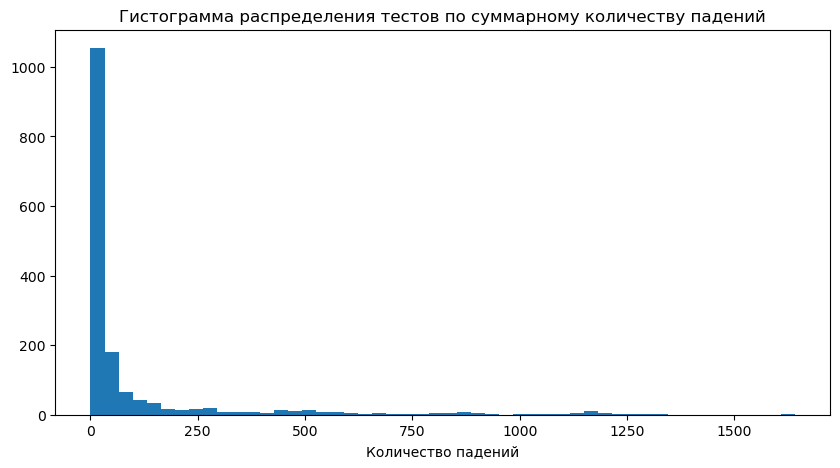

In [10]:
plt.figure(figsize = (10,5))
plt.hist(f_actual.total_crashes, bins=50)
plt.title('Гистограмма распределения тестов по суммарному количеству падений')
plt.xlabel('Количество падений')

<div class="alert alert-block alert-info">
    
- Большинство тестов имеют число падений около 0, что ставит под вопрос их релевантность (если тест никогда не 'упал', то либо тест плох, либо функционал слишком хорош).
- Основная группа тестов падает в диапазоне до 750 раз за всё время существования
- Есть длинный хвост из падений больше 1000. Опять встаёт вопрос о релевантности таких тестов. 
</div>

### Отношение количества падений к количеству запусков 

In [11]:
f_actual["per"] = round(f_actual["total_crashes"] / f_actual["total_runs"] * 100)
f_actual

,name,first_run,last_run,last_crash,total_crashes,total_runs,elapsed_time,category,year,per
0,06_Plate2D_45_turb,2014-03-21,2023-11-11,20.02.23,25,2398,0:0:1,Grid,2014,1.0
1,08_NACA0012_a8_M03,2014-03-20,2023-10-11,20.02.23,25,2319,0:0:1,Grid,2014,1.0
2,0_diam_0_particles,2015-03-09,2023-11-11,02.09.23,22,1959,0:0:24,Dispersed,2015,1.0
3,0_diam_0_particles2,2017-05-22,2023-12-11,02.09.23,14,1534,0:0:1,Dispersed,2017,1.0
4,0_surface_supergroup,2018-09-08,2023-11-11,02.09.23,3,1272,0:1:10,Vizu,2018,0.0
...,...,...,...,...,...,...,...,...,...,...
1695,Zeldonich_CH4_0_05,2023-09-11,2023-11-11,none,0,4,0:0:1,MassTransfer,2023,0.0
1696,Zeldonich_H2,2023-09-11,2023-12-11,none,0,4,0:0:1,MassTransfer,2023,0.0
1697,Zeldovich_CH4_without_temp,2023-09-11,2023-12-11,none,0,4,0:0:3,MassTransfer,2023,0.0
1698,zero_dens_after_adapt_dehn,2020-10-11,2023-11-13,02.09.23,4,541,0:3:58,EDH,2020,1.0


Text(0.5, 0, 'Отношение общего числа падений к общему числу запусков ')

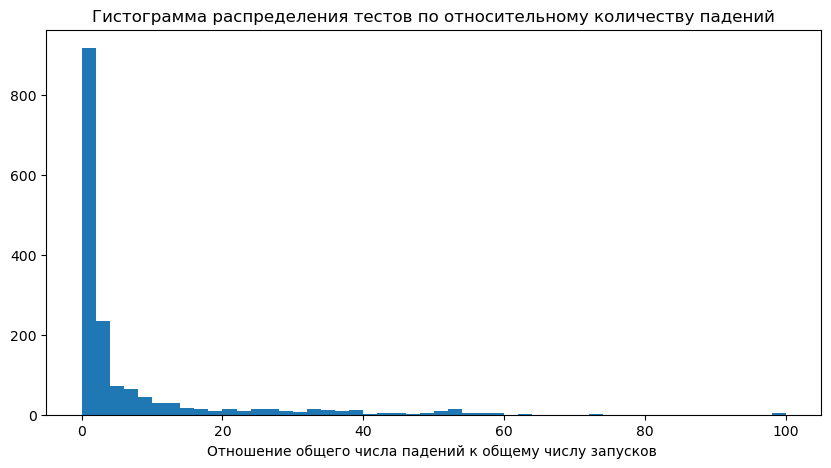

In [12]:
plt.figure(figsize = (10,5))
plt.hist(f_actual.per, bins=50)
plt.title('Гистограмма распределения тестов по относительному количеству падений')
plt.xlabel('Отношение общего числа падений к общему числу запусков ')


<div class="alert alert-block alert-info">
    
Основная группа тестов сосредоточена в диапазоне где падения составляют до 20% от общего количества запусков.
Тесты в диапазоне 20-50 % вызывают беспокойство и требуют анализа.
Можно отметить, что представлены редкие случаи, когда отношение падений к запускам близко к 100%.
    
</div>

### Разделение тестов на группы по количеству падений 

Для удобства поделим тесты на группы: 

0 падений - 1,  
(0;200] - 2,  
(200; 800] - 3,  
(800; и более) - 4

- Падений = 0: тест не отлавливает баги ИЛИ с программой всё ок 
- Падений = 0 - 200 : рабочие кейсы
- Падений = 200 - 800 : ближе к аномальному поведению (надо смотреть историю теста)
- Падений > 800 что-то аномальное происходит. Если падал очень часто, а теперь не падает - ставим под сомнения. Если тест в один момент перестал падать, то возможно он был подогнан так, чтобы не падало больше. 

In [13]:
def crash_category(total_crashes: list)->int:
    """
    Функция присваивает группу по количеству падений.
    """

    if total_crashes == 0:
        return 1
    elif total_crashes > 0 and total_crashes <= 200:
        return 2
    elif total_crashes > 200 and total_crashes <= 800:
        return 3
    else:
        return 4



In [14]:
f_actual['group'] = f_actual['total_crashes'].apply(crash_category)

group
1      60
2    1335
3     153
4      54
Name: name, dtype: int64

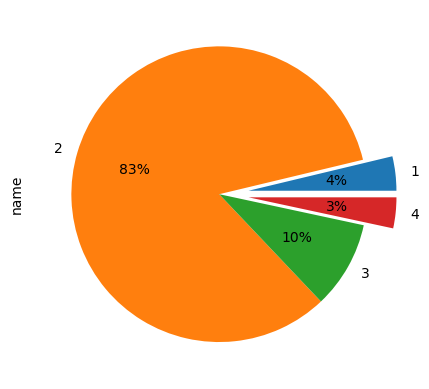

In [15]:
# отрисуем pie chart с группами
explode = (0.2, 0, 0, 0.2) 
f_actual.groupby("group")["name"].count().plot(
    kind="pie", y="group", autopct="%1.0f%%", explode=explode
)
f_actual.groupby('group')['name'].count()

<div class="alert alert-block alert-info">
    
Группа 2 (от 1 до 200 падений) составляет 83% от всех тестов. Предположительно, это рабочие тесты без замечаний.
Оставшиеся 17% тестов требуют внимания и анализа. В особенности: 
* Группа 1 (4%) c нулевым количеством падений
* Группа 4 (3%) с падениями > 800 раз за весь период
    
</div>

### Распределение тестов по категориям 

In [16]:
# группировка тестов по категории тестируемого функционала
f_actual.groupby('category')['name'].count()

category
Acoustic              14
AdvancedSettings      12
BoundaryCondition     77
DLL                   14
Dispersed            161
EDH                   19
FSI                   41
FreeSurface          157
Gap                   25
Grid                 162
HeatTransfer          87
IniConditions         23
Limiters               5
MBC                    2
MassTransfer         118
Modifiers             45
Motion               117
MovingBodies          39
Plugins                2
Radiation             52
Roughness              5
StartStopSaveLoad     71
Subregions            75
Substances            26
Turbulence           118
UserFunction          37
Vizu                  40
tutorial              43
Name: name, dtype: int64

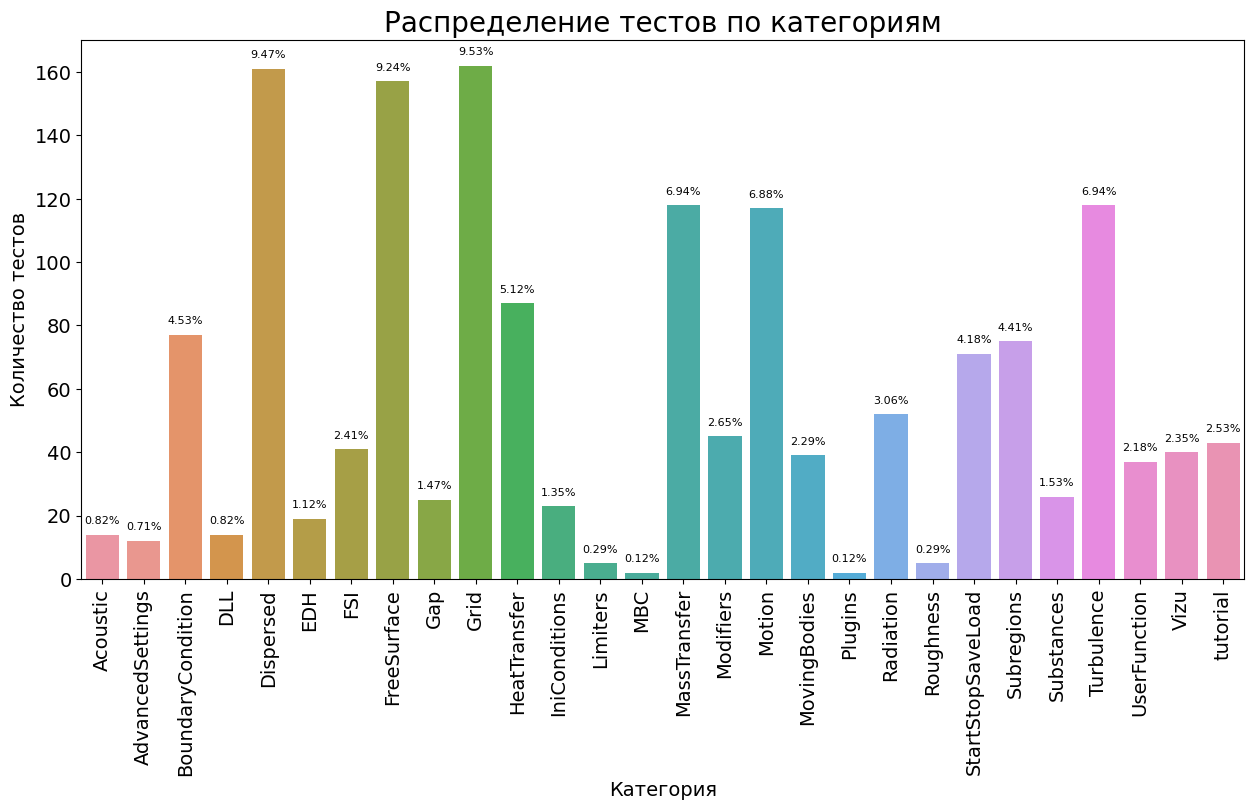

In [17]:
# создаём переменную для дальнейшей отрисовки
norm_target = (f_actual
               .groupby('category')['name']
               .count()
               .rename('percent')
               .reset_index())


plt.figure(figsize=(15, 7))
ax = sns.barplot(x='category', y='percent', data=norm_target)

for p in ax.patches:
    percentage = '{:.2f}%'.format(p.get_height() / 1700 * 100)
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=8)

plt.title('Распределение тестов по категориям', fontsize=20)

plt.xlabel('Категория', fontsize=14)
plt.xticks(rotation = 90)
plt.ylabel('Количество тестов', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

<div class="alert alert-block alert-info">
    
Виден дисбаланс в наполнении базы: превалируют тесты из категорий Dispersed, FreeSurface, Grid
    
</div>

### Связь категорий и числа падений 

In [18]:
# сколько тестов в каждой категории для группы 'падений > 800'
f_actual[f_actual.group==4].groupby('category')['name'].count()

category
EDH              1
FreeSurface     11
Grid             7
HeatTransfer     2
Motion           4
Subregions       4
Turbulence      24
UserFunction     1
Name: name, dtype: int64

<div class="alert alert-block alert-info">
    
В 4-ой группе, где собраны аномально часто падающие тесты опять лидируют группы FreeSurface, Turbulence, Grid
    
</div>

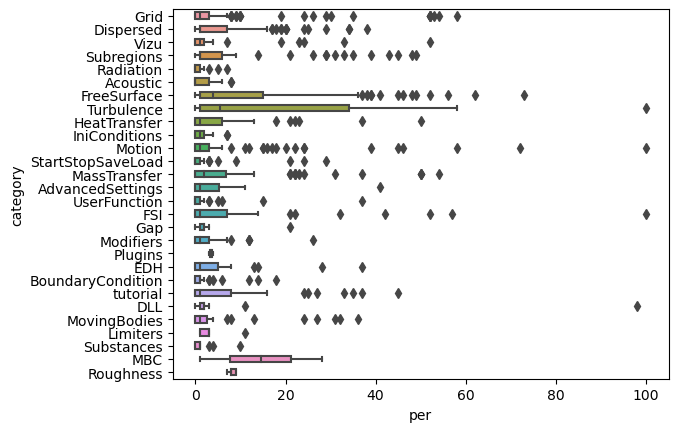

In [19]:
sns.boxplot(y="category", x="per", data=f_actual, orient='h', width=0.5);

<div class="alert alert-block alert-info">
    
В категориях FreSurface, Turbulence, MBC большинство тестов лежит около границы 20% непрохождений. В категориях Turbulence, FSI, Motion, tutorial есть экземпляры со 100% непрохождением.
    
</div>

### Анализ времени проигрывания тестов по категориям 

In [20]:
# добавление доп. столбцов часы, минуты, секунды на основе столбца с затраценным временем
f_actual[['hour', 'min', 'sec']] = f_actual['elapsed_time'].str.split(':', n=2, expand=True) 
f_actual

,name,first_run,last_run,last_crash,total_crashes,total_runs,elapsed_time,category,year,per,group,hour,min,sec
0,06_Plate2D_45_turb,2014-03-21,2023-11-11,20.02.23,25,2398,0:0:1,Grid,2014,1.0,2,0,0,1
1,08_NACA0012_a8_M03,2014-03-20,2023-10-11,20.02.23,25,2319,0:0:1,Grid,2014,1.0,2,0,0,1
2,0_diam_0_particles,2015-03-09,2023-11-11,02.09.23,22,1959,0:0:24,Dispersed,2015,1.0,2,0,0,24
3,0_diam_0_particles2,2017-05-22,2023-12-11,02.09.23,14,1534,0:0:1,Dispersed,2017,1.0,2,0,0,1
4,0_surface_supergroup,2018-09-08,2023-11-11,02.09.23,3,1272,0:1:10,Vizu,2018,0.0,2,0,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,Zeldonich_CH4_0_05,2023-09-11,2023-11-11,none,0,4,0:0:1,MassTransfer,2023,0.0,1,0,0,1
1696,Zeldonich_H2,2023-09-11,2023-12-11,none,0,4,0:0:1,MassTransfer,2023,0.0,1,0,0,1
1697,Zeldovich_CH4_without_temp,2023-09-11,2023-12-11,none,0,4,0:0:3,MassTransfer,2023,0.0,1,0,0,3
1698,zero_dens_after_adapt_dehn,2020-10-11,2023-11-13,02.09.23,4,541,0:3:58,EDH,2020,1.0,2,0,3,58


In [21]:
# изменения типа для новых столбцов
f_actual['hours'] = pd.to_numeric(f_actual['hour'])
f_actual['minutes'] = pd.to_numeric(f_actual['min'])
f_actual['seconds'] = pd.to_numeric(f_actual['sec'])
f_actual = f_actual.drop(['hour', 'min', 'sec'], axis=1)

In [22]:
# объединение информации о времени в один столбец
f_actual['seconds_total'] = f_actual['hours'] * 3600 + f_actual['minutes'] * 60 + f_actual['seconds']
f_actual = f_actual.drop(['hours', 'minutes', 'seconds', 'elapsed_time'], axis=1)
f_actual

,name,first_run,last_run,last_crash,total_crashes,total_runs,category,year,per,group,seconds_total
0,06_Plate2D_45_turb,2014-03-21,2023-11-11,20.02.23,25,2398,Grid,2014,1.0,2,1
1,08_NACA0012_a8_M03,2014-03-20,2023-10-11,20.02.23,25,2319,Grid,2014,1.0,2,1
2,0_diam_0_particles,2015-03-09,2023-11-11,02.09.23,22,1959,Dispersed,2015,1.0,2,24
3,0_diam_0_particles2,2017-05-22,2023-12-11,02.09.23,14,1534,Dispersed,2017,1.0,2,1
4,0_surface_supergroup,2018-09-08,2023-11-11,02.09.23,3,1272,Vizu,2018,0.0,2,70
...,...,...,...,...,...,...,...,...,...,...,...
1695,Zeldonich_CH4_0_05,2023-09-11,2023-11-11,none,0,4,MassTransfer,2023,0.0,1,1
1696,Zeldonich_H2,2023-09-11,2023-12-11,none,0,4,MassTransfer,2023,0.0,1,1
1697,Zeldovich_CH4_without_temp,2023-09-11,2023-12-11,none,0,4,MassTransfer,2023,0.0,1,3
1698,zero_dens_after_adapt_dehn,2020-10-11,2023-11-13,02.09.23,4,541,EDH,2020,1.0,2,238


In [25]:
# распределение часов, потраченных на запуск всех тестов из базы, по категориям
f_actual.groupby('category')['seconds_total'].sum() / 3600

category
Acoustic              1.055556
AdvancedSettings      6.958611
BoundaryCondition     5.844444
DLL                   2.594722
Dispersed            29.970556
EDH                   7.280278
FSI                  11.385000
FreeSurface          53.110278
Gap                   2.105833
Grid                 33.195833
HeatTransfer          9.142778
IniConditions         0.056667
Limiters              0.175556
MBC                   0.011389
MassTransfer         12.877500
Modifiers             1.114167
Motion               20.437222
MovingBodies         13.725278
Plugins               0.026944
Radiation            11.736111
Roughness             0.226667
StartStopSaveLoad     2.282778
Subregions            6.360278
Substances            1.439167
Turbulence           92.045278
UserFunction          0.116667
Vizu                  0.367222
tutorial             52.807500
Name: seconds_total, dtype: float64

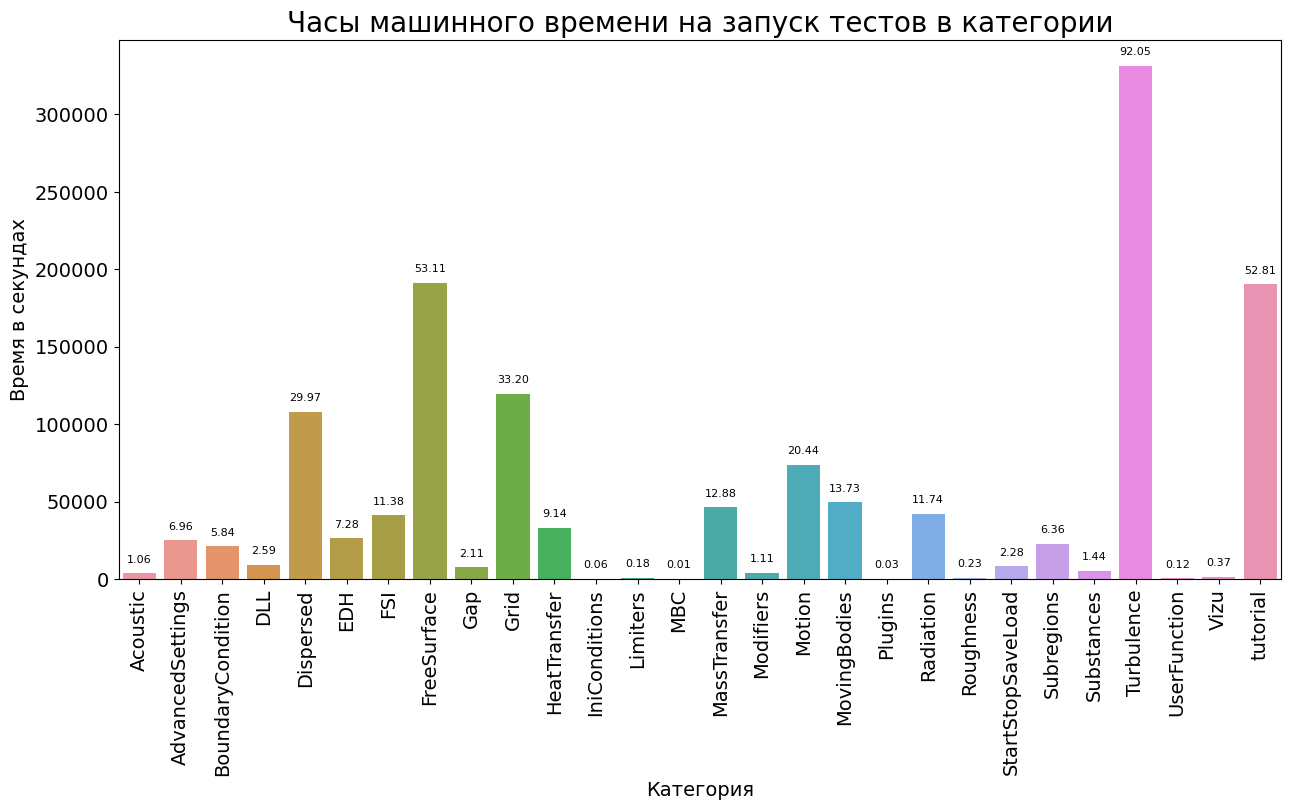

In [26]:
# создание переменной для отрисовки
data_time = (f_actual
               .groupby('category')['seconds_total']
               .sum()
               .rename('hours')
               .reset_index())


plt.figure(figsize=(15, 7))


ax = sns.barplot(x='category', y='hours', data=data_time)


for p in ax.patches:
    percentage = '{:.2f}'.format(p.get_height() / 3600)
    ax.annotate(percentage,  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=8)

plt.title('Часы машинного времени на запуск тестов в категории', fontsize=20)

plt.xlabel('Категория', fontsize=14)
plt.xticks(rotation = 90)
plt.ylabel('Время в секундах', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);



<div class="alert alert-block alert-info">
    
Самые затратные по времени тесты в категории Turbulence, FreeSurface, tutorial.
    
</div>

## Выводы по EDA

Из проведённого анализа можно составить описание текущей базы автотестов:
- Всего в базе хранится 1663 тестов, из которых актуальных 1602
- 1/3 всех тестов добавлены в 2014 году (Возможно устарели. Желательно пересмотреть, очистить ненужные или обновить постановку)
- 83% всех тестов падают не более 200 раз за период, остальные 17% тестов либо не падают, либо падают аномально часто (Желательно сделать ревизию этих 17%)
- Покрытие функционала неравномерное: в некоторых категориях тестов избыточно много (например, в таких как Dispersed, FreeSurface, Grid), в некоторых - недостаточно (MBC, Limiters, Roughness, Acoustic, AdvancedSettings)
- По времени проигрывания лидируют категории Turbulence, FreeSurface, Tutorial - необходимо задуматься о прореживании этих категорий для оптимального использования вычислительных ресурсов

## Feature engineering

Добавим к признаковому описанию ещё одну таблицу с информацией о количестве падений по месяцам за последний год.

In [34]:
fff = pd.read_csv('crash_per_month.csv')
fff.head()

,name,nov22,dec22,jan23,feb23,mar23,apr23,may23,jun23,jul23,aug23,sep23,oct23
0,06_Plate2D_45_turb,0,0,0,1,0,0,0,0,0,0,0,0
1,08_NACA0012_a8_M03,0,0,0,1,0,0,0,0,0,0,0,0
2,0_diam_0_particles,0,0,0,1,0,0,1,0,0,0,1,0
3,0_diam_0_particles2,0,0,0,1,0,0,1,0,0,0,1,0
4,0_surface_supergroup,0,0,0,1,0,0,0,0,0,0,1,0


In [35]:
data = df.merge(fff, on="name", how="left")
data

,name,first_run,last_run,last_crash,total_crashes,total_runs,elapsed_time,category,year,nov22,...,jan23,feb23,mar23,apr23,may23,jun23,jul23,aug23,sep23,oct23
0,06_Plate2D_45_turb,2014-03-21,2023-11-11,20.02.23,25,2398,0:0:1,Grid,2014,0,...,0,1,0,0,0,0,0,0,0,0
1,08_NACA0012_a8_M03,2014-03-20,2023-10-11,20.02.23,25,2319,0:0:1,Grid,2014,0,...,0,1,0,0,0,0,0,0,0,0
2,0_diam_0_particles,2015-03-09,2023-11-11,02.09.23,22,1959,0:0:24,Dispersed,2015,0,...,0,1,0,0,1,0,0,0,1,0
3,0_diam_0_particles2,2017-05-22,2023-12-11,02.09.23,14,1534,0:0:1,Dispersed,2017,0,...,0,1,0,0,1,0,0,0,1,0
4,0_surface_supergroup,2018-09-08,2023-11-11,02.09.23,3,1272,0:1:10,Vizu,2018,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,Zeldonich_CH4_0_05,2023-09-11,2023-11-11,none,0,4,0:0:1,MassTransfer,2023,0,...,0,0,0,0,0,0,0,0,0,0
1696,Zeldonich_H2,2023-09-11,2023-12-11,none,0,4,0:0:1,MassTransfer,2023,0,...,0,0,0,0,0,0,0,0,0,0
1697,Zeldovich_CH4_without_temp,2023-09-11,2023-12-11,none,0,4,0:0:3,MassTransfer,2023,0,...,0,0,0,0,0,0,0,0,0,0
1698,zero_dens_after_adapt_dehn,2020-10-11,2023-11-13,02.09.23,4,541,0:3:58,EDH,2020,0,...,0,1,0,0,0,0,0,0,1,0


#### Преобразование признаков со временем 

In [36]:
data[["hour", "min", "sec"]] = data["elapsed_time"].str.split(":", n=2, expand=True)
data['hours'] = pd.to_numeric(data['hour'])
data['minutes'] = pd.to_numeric(data['min'])
data['seconds'] = pd.to_numeric(data['sec'])
data = data.drop(['hour', 'min', 'sec'], axis=1)

data['seconds_total'] = data['hours'] * 3600 + data['minutes'] * 60 + data['seconds']
data = data.drop(['hours', 'minutes', 'seconds'], axis=1)
data = data.drop(['elapsed_time'], axis=1)
data

,name,first_run,last_run,last_crash,total_crashes,total_runs,category,year,nov22,dec22,...,feb23,mar23,apr23,may23,jun23,jul23,aug23,sep23,oct23,seconds_total
0,06_Plate2D_45_turb,2014-03-21,2023-11-11,20.02.23,25,2398,Grid,2014,0,0,...,1,0,0,0,0,0,0,0,0,1
1,08_NACA0012_a8_M03,2014-03-20,2023-10-11,20.02.23,25,2319,Grid,2014,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0_diam_0_particles,2015-03-09,2023-11-11,02.09.23,22,1959,Dispersed,2015,0,0,...,1,0,0,1,0,0,0,1,0,24
3,0_diam_0_particles2,2017-05-22,2023-12-11,02.09.23,14,1534,Dispersed,2017,0,0,...,1,0,0,1,0,0,0,1,0,1
4,0_surface_supergroup,2018-09-08,2023-11-11,02.09.23,3,1272,Vizu,2018,0,0,...,1,0,0,0,0,0,0,1,0,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,Zeldonich_CH4_0_05,2023-09-11,2023-11-11,none,0,4,MassTransfer,2023,0,0,...,0,0,0,0,0,0,0,0,0,1
1696,Zeldonich_H2,2023-09-11,2023-12-11,none,0,4,MassTransfer,2023,0,0,...,0,0,0,0,0,0,0,0,0,1
1697,Zeldovich_CH4_without_temp,2023-09-11,2023-12-11,none,0,4,MassTransfer,2023,0,0,...,0,0,0,0,0,0,0,0,0,3
1698,zero_dens_after_adapt_dehn,2020-10-11,2023-11-13,02.09.23,4,541,EDH,2020,0,0,...,1,0,0,0,0,0,0,1,0,238


#### Уходим от формата datetime в признаках first_run, last_run, last_crash to days 

In [40]:
#задаём опорную дату - последний день 2023 года
date = dt.datetime(2023, 12 ,31)

In [44]:
#для тестов, где падение отсутствует, установим фиктивную дату = опорной дате
data['last_crash'].replace('none', '31.12.23', inplace=True)

In [46]:
# переводит в формат datetime
data[["first_run", "last_run", "last_crash"]] = data[
    ["first_run", "last_run", "last_crash"]
].apply(pd.to_datetime)

In [47]:
# вычисляем timedelta между значением в колонке и опорной датой
data[["first_run_days", "last_run_days", "last_crash_days"]] = data[
    ["first_run", "last_run", "last_crash"]
].apply(lambda x: (date - x).dt.days)
data.drop(["first_run", "last_run", "last_crash"], axis=1, inplace=True)
data


,name,total_crashes,total_runs,category,year,nov22,dec22,jan23,feb23,mar23,...,may23,jun23,jul23,aug23,sep23,oct23,seconds_total,first_run_days,last_run_days,last_crash_days
0,06_Plate2D_45_turb,25,2398,Grid,2014,0,0,0,1,0,...,0,0,0,0,0,0,1,3572,50,314
1,08_NACA0012_a8_M03,25,2319,Grid,2014,0,0,0,1,0,...,0,0,0,0,0,0,1,3573,81,314
2,0_diam_0_particles,22,1959,Dispersed,2015,0,0,0,1,0,...,1,0,0,0,1,0,24,3219,50,325
3,0_diam_0_particles2,14,1534,Dispersed,2017,0,0,0,1,0,...,1,0,0,0,1,0,1,2414,20,325
4,0_surface_supergroup,3,1272,Vizu,2018,0,0,0,1,0,...,0,0,0,0,1,0,70,1940,50,325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,Zeldonich_CH4_0_05,0,4,MassTransfer,2023,0,0,0,0,0,...,0,0,0,0,0,0,1,111,50,0
1696,Zeldonich_H2,0,4,MassTransfer,2023,0,0,0,0,0,...,0,0,0,0,0,0,1,111,20,0
1697,Zeldovich_CH4_without_temp,0,4,MassTransfer,2023,0,0,0,0,0,...,0,0,0,0,0,0,3,111,20,0
1698,zero_dens_after_adapt_dehn,4,541,EDH,2020,0,0,0,1,0,...,0,0,0,0,1,0,238,1176,48,325


#### Бинаризация для категориального признака (category)

In [48]:
#бинаризуем данные
data_bin = pd.get_dummies(data, columns=['category'])
data_bin

,name,total_crashes,total_runs,year,nov22,dec22,jan23,feb23,mar23,apr23,...,category_Radiation,category_Roughness,category_StartStopSaveLoad,category_Subregions,category_Substances,category_Turbulence,category_UserFunction,category_VerificationTests,category_Vizu,category_tutorial
0,06_Plate2D_45_turb,25,2398,2014,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,08_NACA0012_a8_M03,25,2319,2014,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0_diam_0_particles,22,1959,2015,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0_diam_0_particles2,14,1534,2017,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0_surface_supergroup,3,1272,2018,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,Zeldonich_CH4_0_05,0,4,2023,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1696,Zeldonich_H2,0,4,2023,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1697,Zeldovich_CH4_without_temp,0,4,2023,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1698,zero_dens_after_adapt_dehn,4,541,2020,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
data_bin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1700 entries, 0 to 1699
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   name                        1700 non-null   object
 1   total_crashes               1700 non-null   int64 
 2   total_runs                  1700 non-null   int64 
 3   year                        1700 non-null   int64 
 4   nov22                       1700 non-null   int64 
 5   dec22                       1700 non-null   int64 
 6   jan23                       1700 non-null   int64 
 7   feb23                       1700 non-null   int64 
 8   mar23                       1700 non-null   int64 
 9   apr23                       1700 non-null   int64 
 10  may23                       1700 non-null   int64 
 11  jun23                       1700 non-null   int64 
 12  jul23                       1700 non-null   int64 
 13  aug23                       1700 non-null   int6

## Выводы по feature engineering

Итоговое признаковое описание состоит из столбцов:
- name - название теста
- total_crashes - количество падений за всё время существования теста
- total_runs - количество запусков за всё время существования теста
- first_run_days - количество дней от первого запуска
- last_run_days - количество дней от последнего запуска
- last_chash_days - количество дней от последнего падения
- year - год добавления в базу
- seconds_total - количество секунд, затраченное на запуск теста
- [nov22; oct23] - количество падений по месяцам последнего года
- category_ - бинаризованные данные о категории теста